In [3]:
import sys
sys.executable

'F:\\Anaconda\\python.exe'

In [4]:
!pip install tensorflow

In [6]:
import tensorflow as tf
print(tf.__version__)

2.13.0


In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 240
CHANNELS=8
EPOCHS=50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "MangoLeavesDisease",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 4000 files belonging to 8 classes.


In [4]:
class_names = dataset.class_names
class_names

['Anthracnose',
 'Bacterial Canker',
 'Cutting Weevil',
 'Die Back',
 'Gall Midge',
 'Healthy',
 'Powdery Mildew',
 'Sooty Mould']

In [5]:
len(dataset)

125

In [6]:
125*240

30000

In [7]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 240, 240, 3)
[4 5 6 5 1 0 2 2 1 6 1 3 4 7 7 3 3 7 0 1 6 3 0 2 6 3 4 6 0 7 5 6]


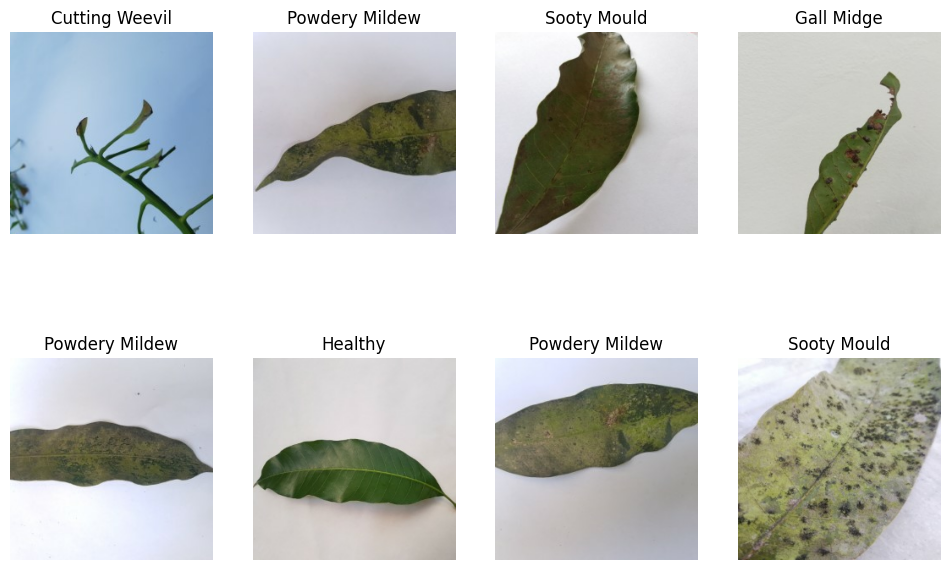

In [14]:
plt.figure(figsize=(12, 12))
for image_batch, labels_batch in dataset.take(1):
    for i in range(8):
        plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [17]:
train_size = 0.8  # You can adjust this proportion as needed
validation_size = 0.1  # Adjust this proportion as needed
test_size = 0.1  # Adjust this proportion as needed

total_size = len(dataset)
train_samples = int(total_size * train_size)
validation_samples = int(total_size * validation_size)
test_samples = int(total_size * test_size)

print("Train samples:", train_samples)
print("Validation samples:", validation_samples)
print("Test samples:", test_samples)

SyntaxError: cannot assign to expression here. Maybe you meant '==' instead of '='? (3914370027.py, line 2)

In [18]:
train_size = 0.8
len(dataset)*train_size

100.0

In [19]:
train_ds = dataset.take(100)
len(train_ds)

100

In [20]:
test_ds = dataset.skip(100)
len(test_ds)

25

In [21]:
val_size=0.1
len(dataset)*val_size

12.5

In [22]:
val_ds = test_ds.take(12)
len(val_ds)

12

In [23]:
test_ds = test_ds.skip(12)
len(test_ds)

13

In [24]:
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)

(32, 240, 240, 3)


In [25]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [26]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [27]:
len(train_ds)

100

In [28]:
len(val_ds)

12

In [29]:
len(test_ds)

13

In [30]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [31]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [32]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [33]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [34]:
import tensorflow as tf
from tensorflow.keras import models, layers

# Define input shape
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 8

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

# You don't need to specify input_shape again here
# model.build(input_shape=input_shape)


In [39]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [40]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 240, 240, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 238, 238, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 119, 119, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 117, 117, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 58, 58, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)       

In [41]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
100/100 [==============================] - 468s 5s/step - loss: 1.7600 - accuracy: 0.2419 - val_loss: 1.5106 - val_accuracy: 0.3828
Epoch 2/50
100/100 [==============================] - 964s 10s/step - loss: 1.2653 - accuracy: 0.4941 - val_loss: 1.1605 - val_accuracy: 0.5026
Epoch 3/50
100/100 [==============================] - 377s 4s/step - loss: 0.9589 - accuracy: 0.6134 - val_loss: 0.8354 - val_accuracy: 0.6797
Epoch 4/50
100/100 [==============================] - 371s 4s/step - loss: 0.7311 - accuracy: 0.7072 - val_loss: 0.7711 - val_accuracy: 0.7083
Epoch 5/50
100/100 [==============================] - 370s 4s/step - loss: 0.6361 - accuracy: 0.7538 - val_loss: 1.0232 - val_accuracy: 0.6146
Epoch 6/50
100/100 [==============================] - 379s 4s/step - loss: 0.5921 - accuracy: 0.7750 - val_loss: 0.5045 - val_accuracy: 0.8281
Epoch 7/50
100/100 [==============================] - 369s 4s/step - loss: 0.4004 - accuracy: 0.8484 - val_loss: 0.4516 - val_accuracy: 0.838

In [42]:
image_batch_resized = tf.image.resize(image_batch, (240, 240))

In [43]:
scores = model.evaluate(test_ds)

13/13 [==============================] - 228s 1s/step - loss: 0.0248 - accuracy: 0.9904


In [44]:
 scores

[0.024772165343165398, 0.9903846383094788]

In [45]:
history

In [46]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 100}

In [47]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [48]:
type(history.history['loss'])

list

In [49]:
len(history.history['loss'])

50

In [50]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.7599672079086304,
 1.265343189239502,
 0.9588500261306763,
 0.731080949306488,
 0.6361081600189209]

In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

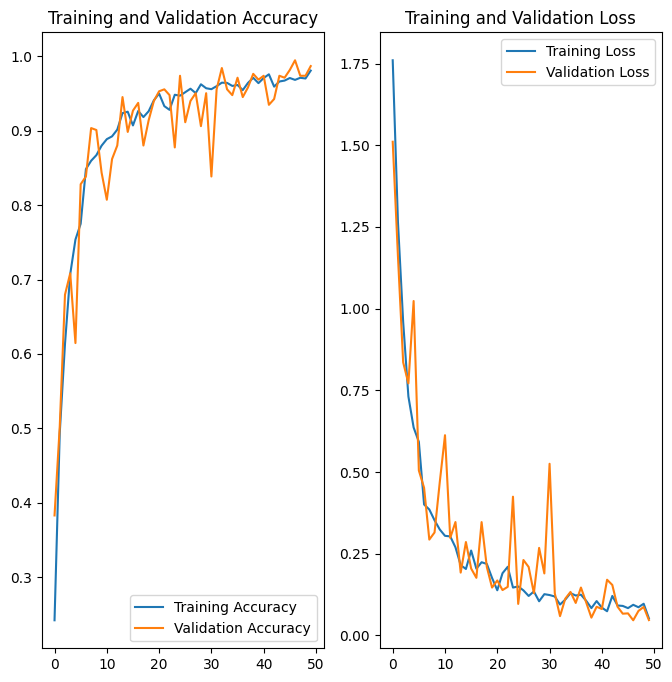

In [52]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc[:EPOCHS], label='Training Accuracy')  # Use acc[:EPOCHS]
plt.plot(range(EPOCHS), val_acc[:EPOCHS], label='Validation Accuracy')  # Use val_acc[:EPOCHS]
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss[:EPOCHS], label='Training Loss')  # Use loss[:EPOCHS]
plt.plot(range(EPOCHS), val_loss[:EPOCHS], label='Validation Loss')  # Use val_loss[:EPOCHS]
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Bacterial Canker
1/1 [==============================] - 12s 12s/step
predicted label: Bacterial Canker


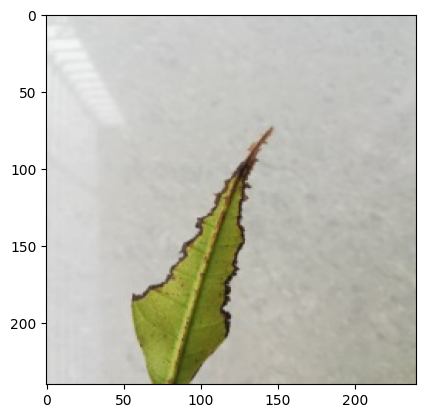

In [53]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [54]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 116ms/step


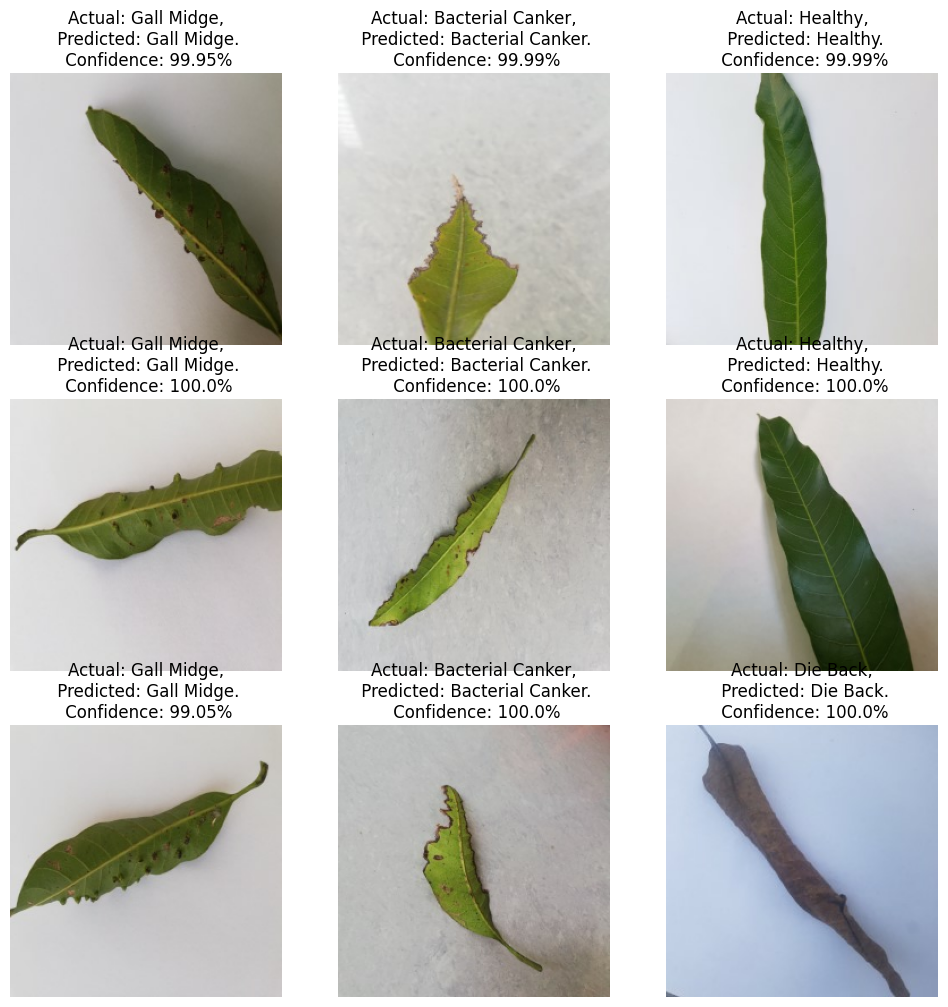

In [61]:
plt.figure(figsize=(12, 12))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [59]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/3\assets


INFO:tensorflow:Assets written to: ../models/3\assets


In [60]:
model_version = 1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets
